# Dataset Overview

The data was obtained from Kaggle https://www.kaggle.com/harlfoxem/housesalesprediction <br>
This dataset contains house data from King's County, Washington, which Seattle is part of. <br>
You can see the more indepth breakdown of the data in https://github.com/hyunlee1999/Machine_Learning_Linear_Regression_House_Prices <br>

# Notebook Overview
In this notebook, I will be implementing the K-Nearest Neighbor (KNN) algorithm to this dataset. KNN algorithm is very simple but can be very powerful. It measures the distance between the whole training set and the individual rows of test set. Then, it picks the k "closest neighbors" by measuring the Euclidian Distance and picking the ones that are shortest distance apart from the test set. <br>

This is very helpful in predicting the house prices because the location of the house really matters in determining the house prices. So, let's get started.

# 1. Average and Standard Deviation of the Test Set
To get the idea of the prices in the data set, here are some helpful numbers.

In [1]:
import pandas as pd
import numpy as np

houseData = pd.read_csv("kc_house_data.csv")
housePrices = houseData["price"].values

avg = np.sum(housePrices)/housePrices.size
std = (np.sum((housePrices - avg)**2)/housePrices.size)**.5

print("The average prices in King's County, WA is", int(avg), "dollars and the standard deviation is", int(std), "dollars" )

The average prices in King's County, WA is 540088 dollars and the standard deviation is 367118 dollars


# 2. Splitting Training Set and Test Set
We need to split off the training set and the test set. <br>
Since the house prices are lop-sided and we don't have much entry, we should use stratified splitting.

In [2]:
houseData["housePriceCategory"] = pd.cut(houseData["price"], bins = [0, 300000, 600000, 1000000, np.inf], labels = [1, 2, 3, 4])
houseData["housePriceCategory"].hist()

I've split the houses according to price, and this looks pretty good. Now, I'll split it according to these prices.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
shuffleSplit = StratifiedShuffleSplit(test_size = 0.3, random_state = 42)
for trainIndex, testIndex in shuffleSplit.split(houseData, houseData["housePriceCategory"]):
    trainSet = houseData.iloc[trainIndex]
    testSet = houseData.iloc[testIndex]
trainSet.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,housePriceCategory
9059,8731900790,20140626T000000,354950.0,4,2.75,2530,7350,1.0,0,0,...,1280,1250,1977,0,98023,47.3130,-122.374,2280,7350,2
13879,9238450330,20141110T000000,330000.0,3,1.00,1070,10563,1.0,0,0,...,1070,0,1969,0,98072,47.7687,-122.166,1840,9638,2
12286,727500030,20140715T000000,815000.0,3,1.50,1370,8671,1.0,0,0,...,1370,0,1955,0,98004,47.6217,-122.198,1580,8671,3
3218,3574801110,20141125T000000,405000.0,4,2.75,2360,7716,1.0,0,0,...,1390,970,1978,0,98034,47.7301,-122.223,2160,8794,2
5287,7754900280,20140623T000000,322200.0,4,2.25,2010,19000,2.0,0,0,...,2010,0,1975,0,98042,47.3734,-122.119,1950,19626,2


# 3. Splitting Features and House Prices in Test and Training Set

In [4]:
trainSetCopy = trainSet.copy()
trainPrices = trainSetCopy["price"]
trainFeatures = trainSetCopy[["lat", "long"]]

testSetCopy = testSet.copy()
testPrices = testSetCopy["price"]
testFeatures = testSetCopy[["lat", "long"]]

# 4. KNN Algorithm Implementation
This KNN algorithm has one hyperparameter, which is number of neighbors (var kCount) <br>
If kCount is greater than 1, then the code will take the average of the prices of k-nearest neighbers. <br>
All of the features were removed in this dataset except for longitude and latitude. We will be strictly comparing house prices based on the location only in this notebook. So, the euclidean distance between two points in this KNN algorithm is proportional to the actual distance between them!

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


trainFeaturesNumpy = trainFeatures.values
trainFeaturesNumpy.shape

class KNN:
    def __init__(self, kCount = 1):
        self.kCount = kCount
    def distance (self, X1, X2):
        dist = np.sum((X1 - X2)**2, axis=1)**.5
        return dist
    def predict(self, trainX, trainY, testX):
        prediction = []
        for i in testX:
            dist = self.distance(trainX, i)
            knnIndex = np.argpartition(dist, self.kCount)
            predictionValue = np.sum(trainY[knnIndex[:self.kCount]])/self.kCount
            prediction.append(predictionValue)
        return np.asarray(prediction)

# 5. K-Linear Regression Model Performance Measure and Interesting Relationship between hyperparameter K (number of Neighbors) and Mean Absolute Error

The mean absolute error was used as the performance measure of the algorithm. In the below code, I've plotted the error agains the number of neighbors, and there's a definite relationship between those two.

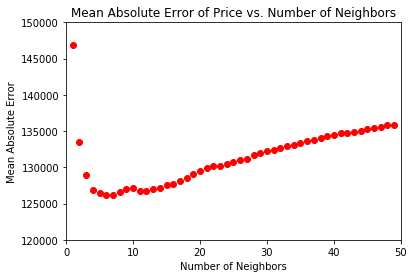

In [6]:
def main():
    maeError = []
    for i in range (1, 50):
        knnRegressor = KNN(i)
        prediction = knnRegressor.predict(trainFeatures.values,trainPrices.values, testFeatures.values)
        error = mean_absolute_error(prediction, testPrices)
        maeError.append(error)
    maeErrorNp = np.asarray(maeError)
    neighborCount = np.arange(1,50)
    plt.plot(neighborCount, maeErrorNp, "ro")
    plt.axis([0, 50, 120000, 150000])
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Mean Absolute Error")
    plt.title("Mean Absolute Error of Price vs. Number of Neighbors")
    plt.show()
    
    
main()

# 6. Thoughts on the Relationship of Hyperparameter K and Error on House Prices

So, we can see from the graph that the error signifantly drops until when K = 4. Then, the the error doesn't have any more significant drops after that. So, the best hyperparameter setting is K = 4. <br>

An interesting thing to note is that the error drops rapidly in 1 <= K <= 4. I think tha the reason for this drop is that one to three closest neighbors of a particular house is not very reflective of its neighborhood. Once K reaches 4, then the average prices for 4 closest neighbor more closely represent the price of that particular house. <br>

Another interesting relationship is that approximately K > 10, you have a linear relationship between the number of neighbors and the mean absolute error. If the number of neighbors increase, then the mean absolute error increases as well. The primary reasons is that once you reach a certain K, then you account for houses that are outside the neighborhood of a particular house. So, the price estimation is inaccurate. <br>


# 7. Future Testing

I think another cool implementation to test is to incorporate linear regression with this K-nearest neighbor algorithm. Then, we can have two hyperparameters, number of neighbors and the weights for linear regressions, to find the best combination for this particular dataset. 